In [85]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import linregress
import requests
import json
from pprint import pprint
from datetime import datetime
import numpy as np

# Setting path to import Csv files.
auto_insurance_to_load = Path("Resources/AutoInsurance.csv")

# Reading CSV files and transforming into Dataframe.
auto_insurance_df = pd.read_csv(auto_insurance_to_load)

#url = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCrashesByLocation?fromCaseYear=2011&toCaseYear=2011&format=json"
url_cali = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?states=6&fromYear=2011&toYear=2011&minNumOfVehicles=1&maxNumOfVehicles=6&format=json"
url_ariz = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?states=4&fromYear=2011&toYear=2011&minNumOfVehicles=1&maxNumOfVehicles=6&format=json"
url_wash = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?states=53&fromYear=2011&toYear=2011&minNumOfVehicles=1&maxNumOfVehicles=6&format=json"
url_ore = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?states=41&fromYear=2011&toYear=2011&minNumOfVehicles=1&maxNumOfVehicles=6&format=json"
url_nev = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?states=32&fromYear=2011&toYear=2011&minNumOfVehicles=1&maxNumOfVehicles=6&format=json"

In [86]:


response = requests.get(url_cali).json()
response_one = requests.get(url_ariz).json()
response_two = requests.get(url_nev).json()
response_three =  requests.get(url_wash).json()
response_four =  requests.get(url_ore).json()

In [87]:
data = response['Results'][0]
data_one = response_one['Results'][0]
data_two = response_two['Results'][0]
data_three = response_three['Results'][0]
data_four = response_four['Results'][0]

In [88]:
cali_df = pd.DataFrame(data)
ariz_df = pd.DataFrame(data_one)
nev_df = pd.DataFrame(data_two)
wash_df = pd.DataFrame(data_three)
ore_df = pd.DataFrame(data_four)

In [89]:
combined_df = pd.concat([cali_df, ariz_df, nev_df, wash_df, ore_df], ignore_index=True)
combined_df.sample(20)

,CountyName,CrashDate,Fatals,Peds,Persons,St_Case,State,StateName,TotalVehicles
3903,WALLA WALLA (71),/Date(1317936600000-0400)/,1,0,1,530325,53,Washington,1
2646,MARICOPA (13),/Date(-62135578800000-0500)/,1,1,0,40036,4,Arizona,1
1788,SAN BERNARDINO (71),/Date(-62135578800000-0500)/,1,0,1,61794,6,California,1
1143,FRESNO (19),/Date(1308713880000-0400)/,1,1,5,61147,6,California,1
3716,PIERCE (53),/Date(1297291740000-0500)/,1,1,1,530134,53,Washington,1
3405,WASHOE (31),/Date(1301364780000-0400)/,1,0,2,320040,32,Nevada,2
642,SAN BERNARDINO (71),/Date(1302162900000-0400)/,2,0,4,60645,6,California,2
1165,RIVERSIDE (65),/Date(1304223240000-0400)/,1,0,2,61169,6,California,1
452,LOS ANGELES (37),/Date(1301086620000-0400)/,1,1,1,60454,6,California,1
1620,SAN BERNARDINO (71),/Date(1313275140000-0400)/,1,1,1,61626,6,California,1


In [90]:
# number of cars involved in crashes

veh_count_df = combined_df.groupby(["StateName"])["TotalVehicles"].sum()
veh_count_df

StateName
Arizona       1125
California    3914
Nevada         337
Oregon         438
Washington     609
Name: TotalVehicles, dtype: int64

In [91]:
auto_insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9135 entries, 0 to 9134
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9135 non-null   object 
 1   State                          9135 non-null   object 
 2   Customer Lifetime Value        9135 non-null   float64
 3   Response                       9135 non-null   object 
 4   Coverage                       9135 non-null   object 
 5   Education                      9135 non-null   object 
 6   Effective To Date              9135 non-null   object 
 7   EmploymentStatus               9135 non-null   object 
 8   Gender                         9135 non-null   object 
 9   Income                         9135 non-null   int64  
 10  Location Code                  9135 non-null   object 
 11  Marital Status                 9135 non-null   object 
 12  Monthly Premium Auto           9135 non-null   i

In [92]:


unclean_auto_df =  auto_insurance_df[[
                            "State",
                            "Gender",
                            "Coverage",
                            "Education",
                            "Income",
                            "Number of Policies",
                            "Marital Status",
                            "EmploymentStatus",
                            "Policy Type",
                            "Policy",
                            "Renew Offer Type",
                            "Monthly Premium Auto",
                            "Total Claim Amount",
                            "Vehicle Class", 
                            "Vehicle Size",
                            "Customer Lifetime Value"
                            ]]

auto_df = unclean_auto_df.drop(index=0)

income_df = auto_df.loc[auto_df["Income"] != 0]
income_df[["Income","Monthly Premium Auto","Customer Lifetime Value","Total Claim Amount","Number of Policies",]].corr()

,Income,Monthly Premium Auto,Customer Lifetime Value,Total Claim Amount,Number of Policies
Income,1.000000,-0.012372,0.002915,-0.221879,-0.001324
Monthly Premium Auto,-0.012372,1.000000,0.399491,0.636084,-0.026795
Customer Lifetime Value,0.002915,0.399491,1.000000,0.245464,0.022683
Total Claim Amount,-0.221879,0.636084,0.245464,1.000000,-0.012253
Number of Policies,-0.001324,-0.026795,0.022683,-0.012253,1.000000


Q -- Is there correlation between Total Claim amount/Customer Lifetime Value versus Monthly premiums? If so, is it strong enough to create a prediction model?

In [93]:
def linear_regression(x_values, y_values):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    return print(f"The R-value is {rvalue**2}"),plt.scatter(x_values,y_values,color="gold",edgecolors="black",alpha=0.3),plt.plot(x_values,regress_values,"b-"),plt.annotate(line_eq,(max(x_values),min(y_values)),fontsize=10,color="red")

The R-value is 0.1595930222935034


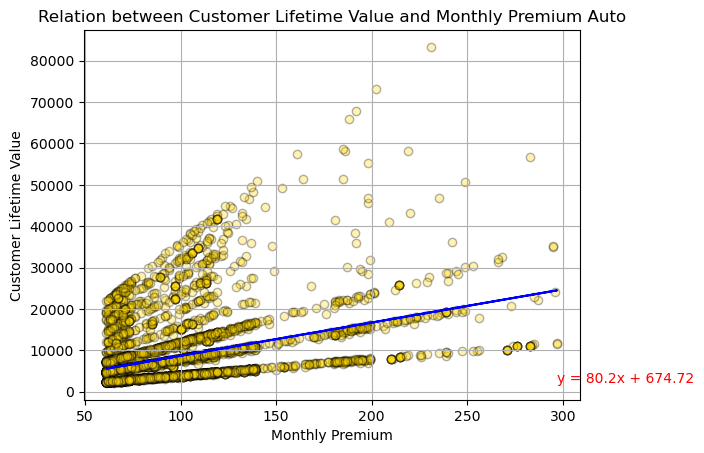

In [94]:
x_values = income_df["Monthly Premium Auto"]
y_values = income_df["Customer Lifetime Value"]
linear_regression(x_values,y_values)
plt.xlabel("Monthly Premium")
plt.ylabel("Customer Lifetime Value")
plt.title("Relation between Customer Lifetime Value and Monthly Premium Auto")
plt.grid(True)
plt.savefig("Output/Scatter1.png")

The R-value is 0.4046024951347791


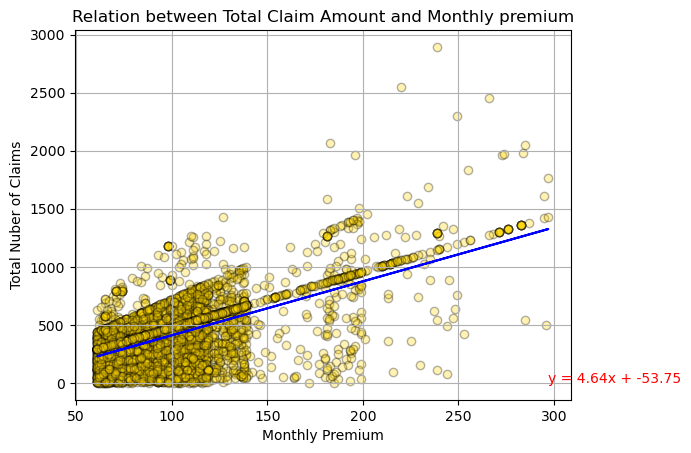

In [95]:
x_values = income_df["Monthly Premium Auto"]
y_values = income_df["Total Claim Amount"]
linear_regression(x_values,y_values,)
plt.xlabel("Monthly Premium")
plt.ylabel("Total Nuber of Claims")
plt.title("Relation between Total Claim Amount and Monthly premium")
plt.grid(True)
plt.savefig("Output/Scatter2.png")

Written Analysis: 


The Relation between Customer Lifetime Value and Monthly Premiums is positive which indicates that a higher lifetime value tends to have a higher monthly Premium . The R-value of 0.1595 suggests that although the relation is positive there are possibly multiple other factors that could impact the monthly insurance premium. Therefore, in order to build a predictive model with this more data and advanced techniques would need to be implemented.

There is a positive corelation between Total Number of claims & Monthly Premium indicated by its R value of 0.4046. This may not indicate a highly predictive model, it still provides a significant amount of explanatory power. This model can be used to gain valuable insights, make informed decisions, and guide further improvements. Continuously refining the model and incorporating more data and advanced techniques can help enhance its predictive capabilities. This model can be a good start point but would need more sophistication to be accurate. 